In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

In [2]:
%matplotlib inline
sns.set(style="whitegrid")

In [6]:
df = pd.read_csv('Tumor_Detection.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
df.shape

(569, 32)

In [8]:
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [9]:
df = df.dropna().reset_index(drop=True)

0    357
1    212
Name: diagnosis, dtype: int64


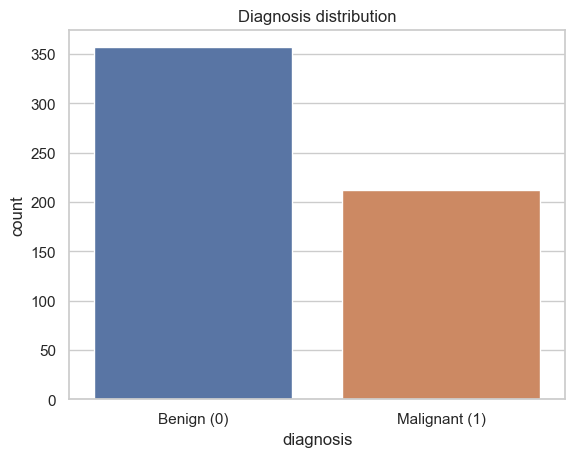

In [10]:
if df['diagnosis'].dtype == object:
    df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})

print(df['diagnosis'].value_counts())
sns.countplot(x='diagnosis', data=df);
plt.xticks([0,1], ['Benign (0)', 'Malignant (1)']);
plt.title('Diagnosis distribution');

(diagnosis               1.000000
 concave points_worst    0.793566
 perimeter_worst         0.782914
 concave points_mean     0.776614
 radius_worst            0.776454
 perimeter_mean          0.742636
 area_worst              0.733825
 radius_mean             0.730029
 area_mean               0.708984
 concavity_mean          0.696360
 Name: diagnosis, dtype: float64,
 smoothness_mean            0.358560
 symmetry_mean              0.330499
 fractal_dimension_worst    0.323872
 compactness_se             0.292999
 concavity_se               0.253730
 fractal_dimension_se       0.077972
 symmetry_se               -0.006522
 texture_se                -0.008303
 fractal_dimension_mean    -0.012838
 smoothness_se             -0.067016
 Name: diagnosis, dtype: float64)

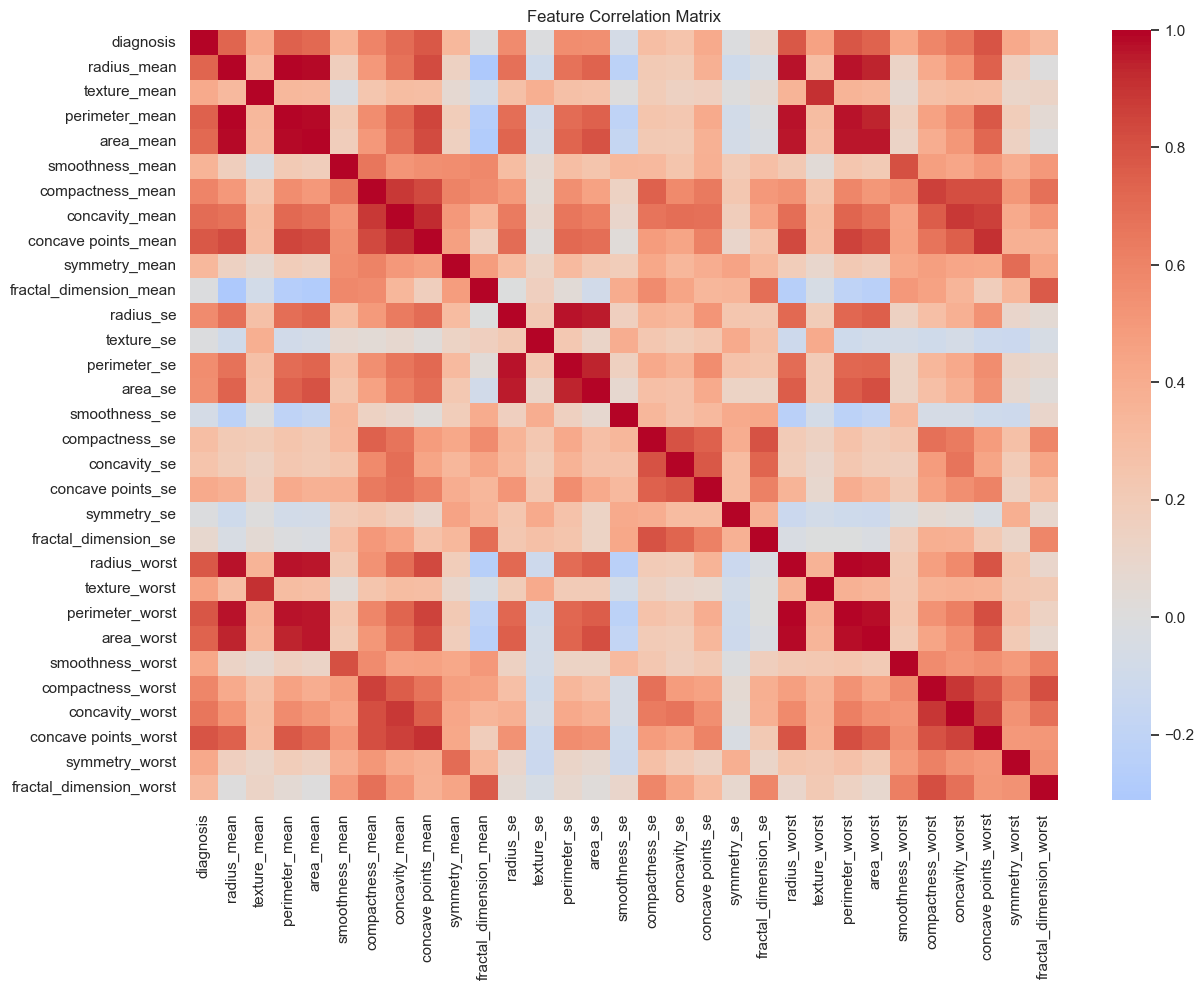

In [11]:
# Summary stats
df.describe().T

# Correlation matrix
corr = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix');

# Show features most correlated with diagnosis
corr_with_target = corr['diagnosis'].sort_values(ascending=False)
corr_with_target.head(10), corr_with_target.tail(10)

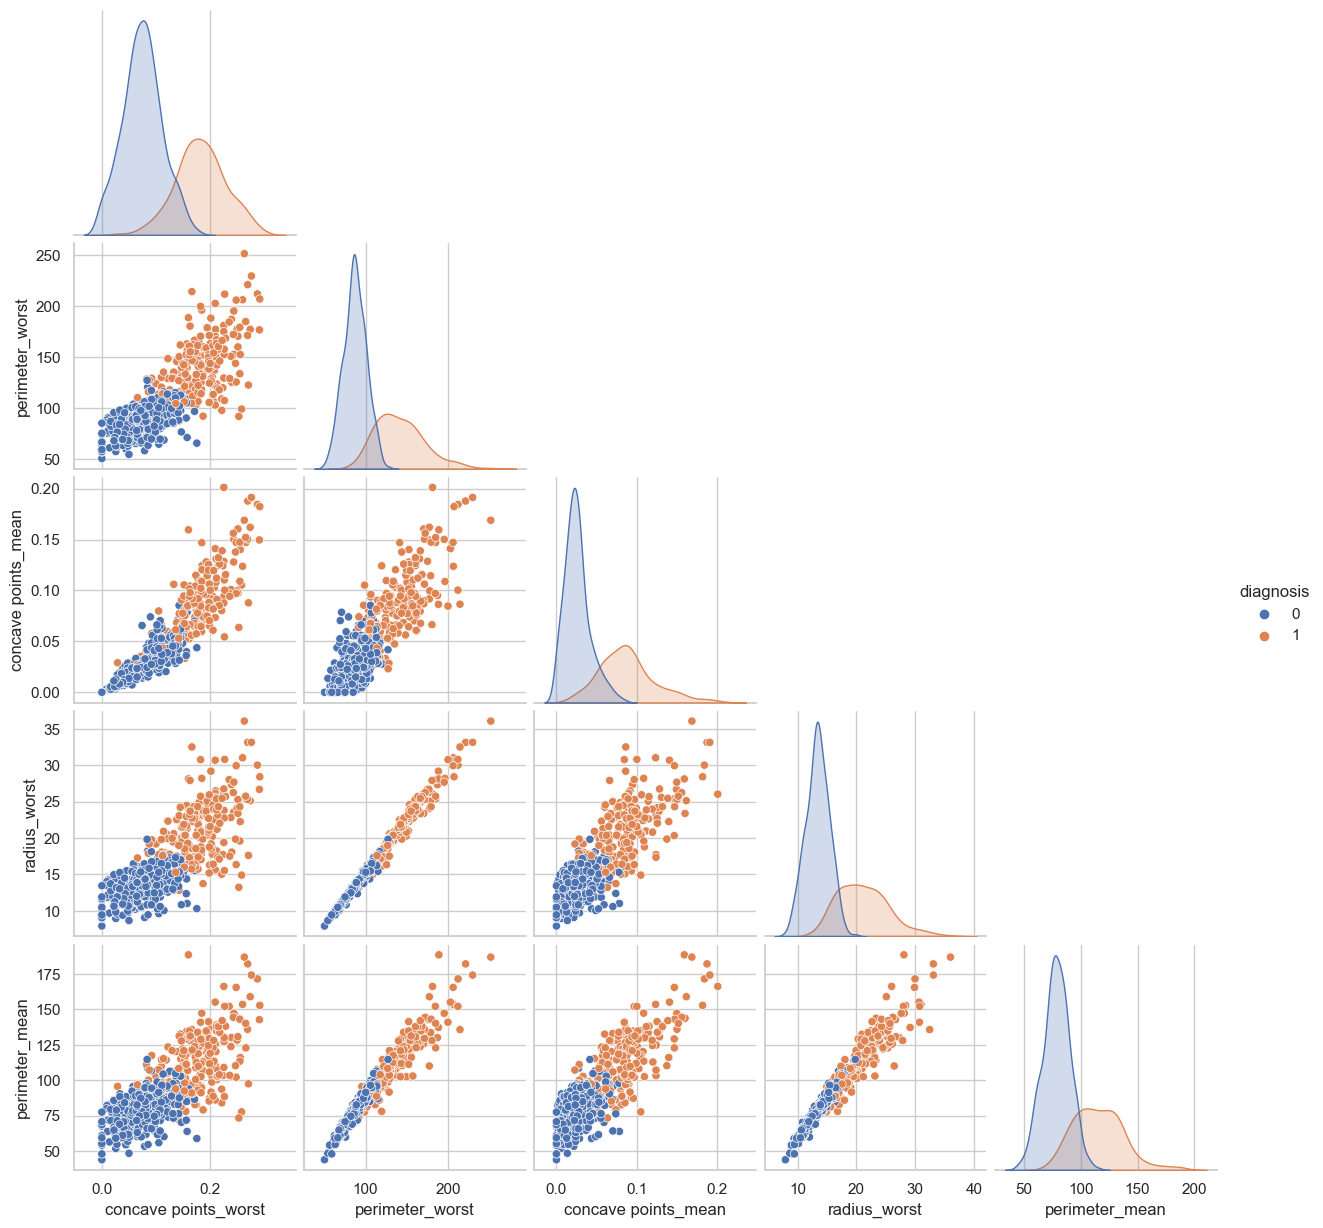

In [12]:
# Top features most correlated with diagnosis (excluding diagnosis itself)
top_feats = corr_with_target.abs().sort_values(ascending=False).index[1:6].tolist()
top_feats
sns.pairplot(df[top_feats + ['diagnosis']], hue='diagnosis', diag_kind='kde', corner=True)

In [13]:
# Features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Keep only numeric features (if any stray strings)
X = X.select_dtypes(include=[np.number])

# Scale features (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (stratify to keep class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (455, 30) Test shape: (114, 30)


In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]   # probability for positive class

Test Accuracy: 0.9736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

5-fold CV accuracy: mean=0.9543, std=0.0217


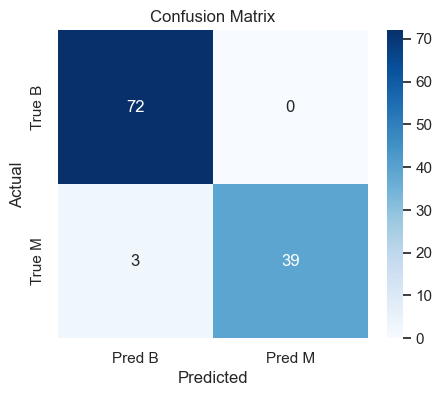

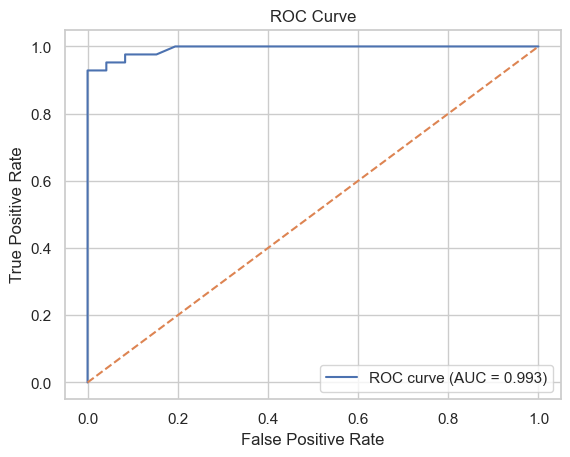

In [15]:
# Accuracy and classification report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred B','Pred M'], yticklabels=['True B','True M'])
plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.title('Confusion Matrix');

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.legend(); plt.title('ROC Curve');

# 5-fold cross-validation on whole scaled data
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1)
print("5-fold CV accuracy: mean={:.4f}, std={:.4f}".format(cv_scores.mean(), cv_scores.std()))

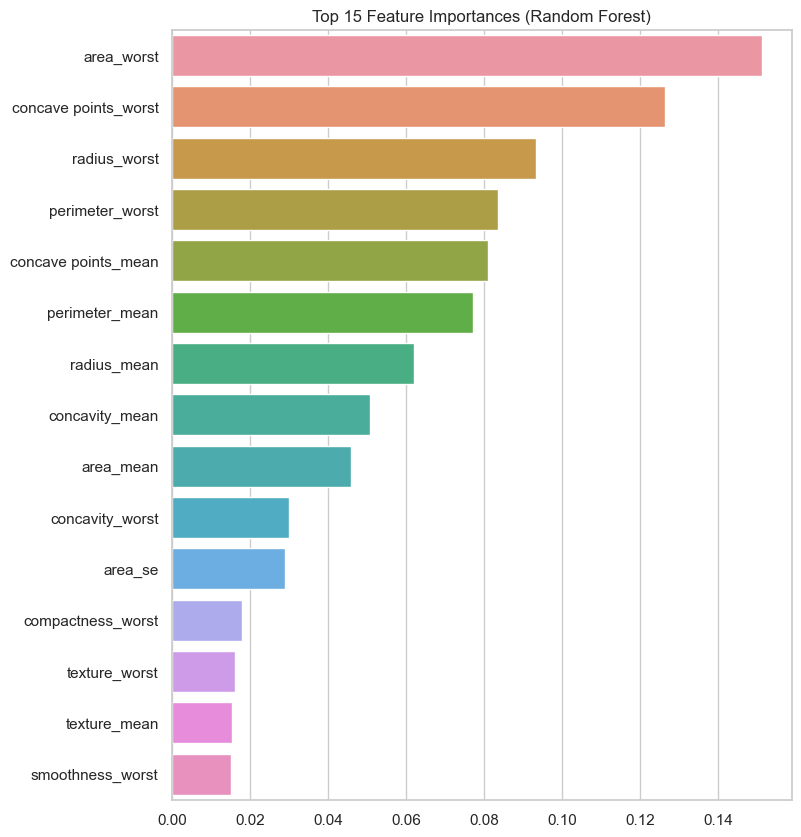

In [16]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,10))
sns.barplot(x=importances[:15], y=importances[:15].index)
plt.title('Top 15 Feature Importances (Random Forest)');

In [17]:
joblib.dump(rf, 'rf_tumor_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':[100,200],
    'max_depth':[None, 5, 10],
    'min_samples_split':[2,5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} 0.9626373626373628
